# Building Your Multimodal Search Store: Empowering Healthcare with Azure 🚀

Welcome to this hands‑on tutorial where we combine cutting‑edge AI, Azure Cognitive Search, and clinical image analysis to build a vector‑based knowledge store. In this session, you’ll learn how to leverage the MedImageInsight embeddings model to search and retrieve similar chest X‑ray images based on their semantic content. Along the way, we’ll also explore the healthcare significance of DICOM images and key chest X‑ray classifications such as **Cardiomegaly, No Findings, Pleural Effusion/Atelectasis,** and **Support Devices**.

> **Did you know?**  
> DICOM (Digital Imaging and Communications in Medicine) is the standard format for medical imaging data. It contains not only the image but also rich metadata that helps radiologists diagnose conditions. Chest X‑rays are one of the most common and informative imaging studies in healthcare, assisting in the detection of heart enlargement (cardiomegaly), fluid in the lungs (pleural effusion), lung collapse (atelectasis), and even the presence of support devices such as pacemakers.

---

## 📝 What You’ll Build

In this tutorial, you will create an end‑to‑end multimodal search solution that:
- **Generates embeddings:** Uses the MedImageInsight model to convert chest X‑ray images into high‑dimensional vectors capturing their visual and semantic features.
- **Indexes documents:** Combines image metadata (e.g., image name, category, and clinical label) with the embedding vector and uploads them to an Azure Cognitive Search index.
- **Performs vector searches:** Retrieves and displays similar images from your index based on a query image’s embedding vector.

---

## 🔧 Prerequisites

Before you start, make sure you have:

- An **Azure Subscription**
- Access to **AI Foundry** and **AI Search**
- A **GPU Quota** to deploy MedImageInsights
- [Python Magic](https://pypi.org/project/python-magic/) installed for image handling
- A basic understanding of DICOM images and chest X‑ray interpretation

---

## 📚 Our Approach

We will walk through the following key steps:

1. **Setup & Imports:** Load necessary libraries and set up your Azure resources.
2. **Testing MedImageInsight:** Verify that the embedding model correctly processes a sample chest X‑ray.
3. **Creating the Embedding Index:** Generate embeddings for your entire image catalog, representing both a description and image and merge them with metadata.
4. **Baseline Image & Text Search:** Select a sample image, generate its embedding, and perform a vector search to retrieve similar images. Similarly generate a description and use that to conduct a search image as well.
5. **Performance Optimization:** Discuss tuning techniques to refine the search results and improve precision.

### Healthcare Domain Spotlight: Chest X‑ray Classifications

- **Cardiomegaly:** Indicates an enlarged heart, often associated with various cardiac conditions.
- **No Findings:** Represents a normal chest X‑ray with no abnormal signs.
- **Pleural Effusion/Atelectasis:**  
  - **Pleural Effusion:** Fluid accumulation in the pleural space surrounding the lungs.  
  - **Atelectasis:** Partial or complete collapse of a lung, reducing gas exchange.
- **Support Devices:** Includes medical devices such as pacemakers or endotracheal tubes visible on the X‑ray, critical for patient management.

Understanding these classifications is vital because each category informs different diagnostic and treatment pathways in clinical settings.

---

# 💻 Notebook Walkthrough

### 0. Imports and Setup

Begin by importing all required libraries, setting up Azure Cognitive Search, and preparing your environment for processing DICOM files and image embeddings.



In [1]:
from src.aoai.aoai_helper import AzureOpenAIManager
from dotenv import load_dotenv
from azure.search.documents import SearchClient
from azure.core.credentials import AzureKeyCredential
import pandas as pd
import json
from azure.storage.blob import BlobServiceClient, ContentSettings
from azure.search.documents.indexes import SearchIndexClient
from azure.search.documents.indexes.models import (
    SearchIndex,
    SearchField,
    SimpleField,
    SearchableField,
    SearchFieldDataType,
    VectorSearch,
    HnswAlgorithmConfiguration,
    HnswParameters,
    VectorSearchProfile
)
import os
import pydicom
import requests
import matplotlib.pyplot as plt
from src.clients.medimageinsight import MedImageInsightClient
from src.utils.io import upload_dicom_to_blob
from src.aifoundry.maap import generate_medical_image_embeddings, generate_nonclinical_radiology_report
from src.utils.manip import normalize_document_key, extract_nonclinical_description
from src.utils.stats import evaluate_precision_at_k, display_precision_table, display_source_and_image_search_results, display_source_and_text_search_results

load_dotenv()

# Setup configuration variables for Azure and MedImageInsight
search_endpoint = os.getenv("AZURE_AI_SEARCH_SERVICE_ENDPOINT")
search_admin_key = os.getenv("AZURE_AI_SEARCH_ADMIN_KEY")
search_index_name = os.getenv("AZURE_IMAGES_SEARCH_INDEX_NAME", "med-images-index")
aoai_client = AzureOpenAIManager()
embedding_image_dim = int(os.environ.get("MEDIMAGEPARSE_MODEL_DIMENSIONS", "1024"))
embedding_text_dim = int(os.environ.get("AZURE_OPENAI_EMBEDDING_DIMENSIONS"))
blob_connection_string = os.environ.get("AZURE_STORAGE_CONNECTION_STRING")
blob_container_name = os.environ.get("AZURE_IMAGES_CONTAINER_NAME", "medical-images")
root = os.path.dirname(os.getcwd())
images_folder = os.path.join(root, 'utils', 'data', 'images')
images_label_csv = os.path.join(images_folder, '.csv')
endpoint = os.environ.get("MI2_MODEL_ENDPOINT")
cxr_endpoint = os.environ.get("CXR_MODEL_ENDPOINT")
med_image_insight_client = MedImageInsightClient()

### 1. Test Healthcare Foundational Model Functionality 🎯

Test the embedding generation by processing a sample DICOM image. This step ensures that the MedImageInsight model is correctly deployed and ready to generate embeddings from your chest X‑rays.

200


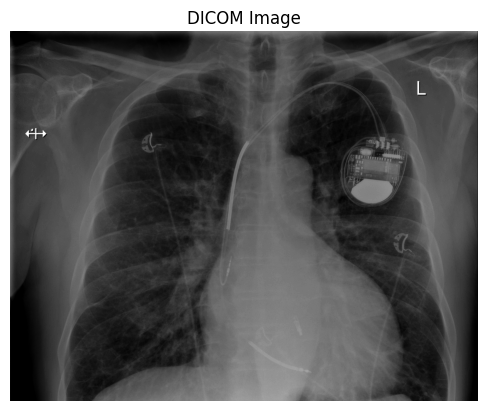

In [2]:
import glob
image_files = list(glob.glob(f"{root}/utils/data/images/raw" + "/*.dcm"))
image=image_files[43]

encoded_image = med_image_insight_client.read_and_encode_image(image=image)

data = {
    "input_data": {
        "columns": ["image", "text"],
        "index": [0],
        "data": [
            [encoded_image, "Cardiomegaly"]
        ],
    },
    "params": {"get_scaling_factor": True},
}

headers = {
    "Content-Type": "application/json",
    "Authorization": f"Bearer {os.environ.get('MI2_MODEL_KEY')}"
}

url = os.environ.get("MI2_MODEL_ENDPOINT")
response = requests.post(url, headers=headers, json=data)
print(response.status_code)

# Load and display a DICOM image sample
ds = pydicom.dcmread(image)
img_array = ds.pixel_array

plt.imshow(img_array, cmap="gray")
plt.title("DICOM Image")
plt.axis("off")
plt.show()

We also want to ensure we can generate some useful clinical information regarding the radiology images, and for that we use the CxrReportGen model to simulate a report for the image. This can be used to provide a more detailed description of the image for search purposes, and will be used in a non-clinical context.

In [3]:
encoded_image = med_image_insight_client.read_and_encode_image(image=image)

data = {
  "input_data": {
    "data": [
      [
        encoded_image,
        "Diagnosis Cardiomegaly"
      ]
    ],
    "columns": [
      "frontal_image",
      "indication"
    ],
    "index": [
      0
    ]
  }
}

headers = {
    "Content-Type": "application/json",
    "Authorization": f"Bearer %s" % os.environ.get("CXR_MODEL_KEY"),
}

url = os.environ.get("CXR_MODEL_ENDPOINT")
response = requests.post(url, headers=headers, json=data)

extract_nonclinical_description(response.json()[0])

'The heart is enlarged. The lungs are hyperinflated. There is no chf. There is no infiltrate. A pacemaker lead is observed in the region of the right ventricle.'

### 2. Building the Image & Data Embedding Index 🔍

Generate embeddings for each DICOM image from your catalog. For each image, you’ll upload the file to Azure Blob Storage, compute its embedding using the MedImageInsight model, and store the resulting vector along with metadata in your search index. We also want to generate a textual report for the image to provide a more detailed description of the image for search purposes. 

With our example, we only have the image labels which describes the diagnosis of the image. This can be used for a field search, we can also use CxrReportGen to describe a more detailed description of the image as a representation. We will create a field **non_clinical_description** to reflect the values of this, as the image should be not be used in replacement of true medical opinion and is merely to serve as an example.

In [4]:
# labeled images
dcm_labels = os.path.join(root, "utils", "data", "images", "dcm_labels.csv")

# storage helpers
blob_service_client = BlobServiceClient.from_connection_string(blob_connection_string)
container_client = blob_service_client.get_container_client(blob_container_name)

# search
search_client = SearchClient(
    endpoint=search_endpoint,
    index_name=search_index_name,
    credential=AzureKeyCredential(search_admin_key)
)

In [5]:
df = pd.read_csv(dcm_labels)
df = df.rename(columns={
    "Name": "name",
    "Label Category": "label_category",
    "Label": "label"
})

In [6]:
documents = []  # list of documents to upsert in Azure Search
image_folder = os.path.join(root, "utils", "data", "images", "raw") 

# upload into blob and generate the DF for Search processing
for idx, row in df.iterrows():
    file_name = row["name"]
    # Construct the full path to the DICOM file
    file_path = os.path.join(image_folder, file_name)
    
    # Upload the file to Blob Storage under the "raw" folder
    blob_url = upload_dicom_to_blob(file_path, container_client, folder="raw")
    
    # Generate the embedding and scaling factor using the helper function
    encoded_image = med_image_insight_client.read_and_encode_image(image=file_path)
    
    image_embedding_result = generate_medical_image_embeddings(encoded_image, row['label_category'])
    image_vector = image_embedding_result.get("image_features")[0] # the embedding vector
    image_scaling_factor = image_embedding_result.get("scaling_factor")
    
    text_embedding_result = generate_nonclinical_radiology_report(encoded_image, row['label_category'])
    non_clinical_description = extract_nonclinical_description(text_embedding_result)
    text_vector_response = aoai_client.generate_embedding(non_clinical_description)
    text_vector = json.loads(text_vector_response)['data'][0]['embedding']
    
    # Create a document matching the Azure Search index schema
    doc = {
        "name": normalize_document_key(file_name),
        "label_category": row["label_category"],
        "label": str(row["label"]),
        "image_vector": image_vector,
        "nonclinical_description": non_clinical_description,
        "text_vector" : text_vector,
        "blob_url": blob_url,
        "scaling_factor": image_scaling_factor
    }
    documents.append(doc)

Define the definition of the index and load our documents!

In [7]:
# Define the index fields
fields = [
    # The 'name' field is used as the unique key
    SimpleField(
        name="name",
        type=SearchFieldDataType.String,
        key=True,
        retrievable=True,
        sortable=True,
        filterable=True
    ),
    # Searchable text fields for metadata
    SearchableField(name="label_category", type=SearchFieldDataType.String),
    SearchableField(name="nonclinical_description", type=SearchFieldDataType.String),
    SearchableField(name="label", type=SearchFieldDataType.Int32),
    # The vector field; must be defined with the proper dimension and linked to a vector search profile
    SearchField(
        name="image_vector",
        type=SearchFieldDataType.Collection(SearchFieldDataType.Single),
        vector_search_dimensions=embedding_image_dim,
        vector_search_profile_name="myHnswNewProfile"
    ),
    SearchField(
        name="text_vector",
        type=SearchFieldDataType.Collection(SearchFieldDataType.Single),
        vector_search_dimensions=embedding_text_dim,
        vector_search_profile_name="myHnswNewProfile"
    ),
    # The blob URL where the image is stored
    SimpleField(
        name="blob_url",
        type=SearchFieldDataType.String,
        retrievable=True
    ),
    # The scaling factor from your embedding response
    SimpleField(
        name="scaling_factor",
        type=SearchFieldDataType.Double,
        retrievable=True
    )
]

# Configure the vector search settings using the HNSW algorithm
vector_search = VectorSearch(
    algorithms=[
        HnswAlgorithmConfiguration(
            name="myHnswNew",
            parameters=HnswParameters(
                m=4, 
                ef_construction=400,
                ef_search=500,
            )
        )
    ],
    profiles=[
        VectorSearchProfile(
            name="myHnswNewProfile",
            algorithm_configuration_name="myHnswNew"
        )
    ]
)

# Create the SearchIndex object including the fields and the vector search configuration
index = SearchIndex(
    name=search_index_name,
    fields=fields,
    vector_search=vector_search
)

index_client = SearchIndexClient(
    endpoint=search_endpoint,
    credential=AzureKeyCredential(search_admin_key)
)

result = index_client.create_or_update_index(index)
print(f"Index '{result.name}' created or updated successfully.")

Index 'med-images-index' created or updated successfully.


In [8]:
# upload the documents to search
try:
    upload_result = search_client.upload_documents(documents=documents)
except Exception as e:
    print("Error uploading documents:", e)


---

### 3. Baseline Search and Retrieve Using Images 🔎

Now comes the fun part! Use the generated embedding vectors to perform a similarity search. By selecting an image from your dataset, the system retrieves and displays the top‑n similar images – showcasing the power of vector search in a multimodal knowledge store.

Let's do a natural language search against our search store and see what comes up, based on our non_clinical_description field.

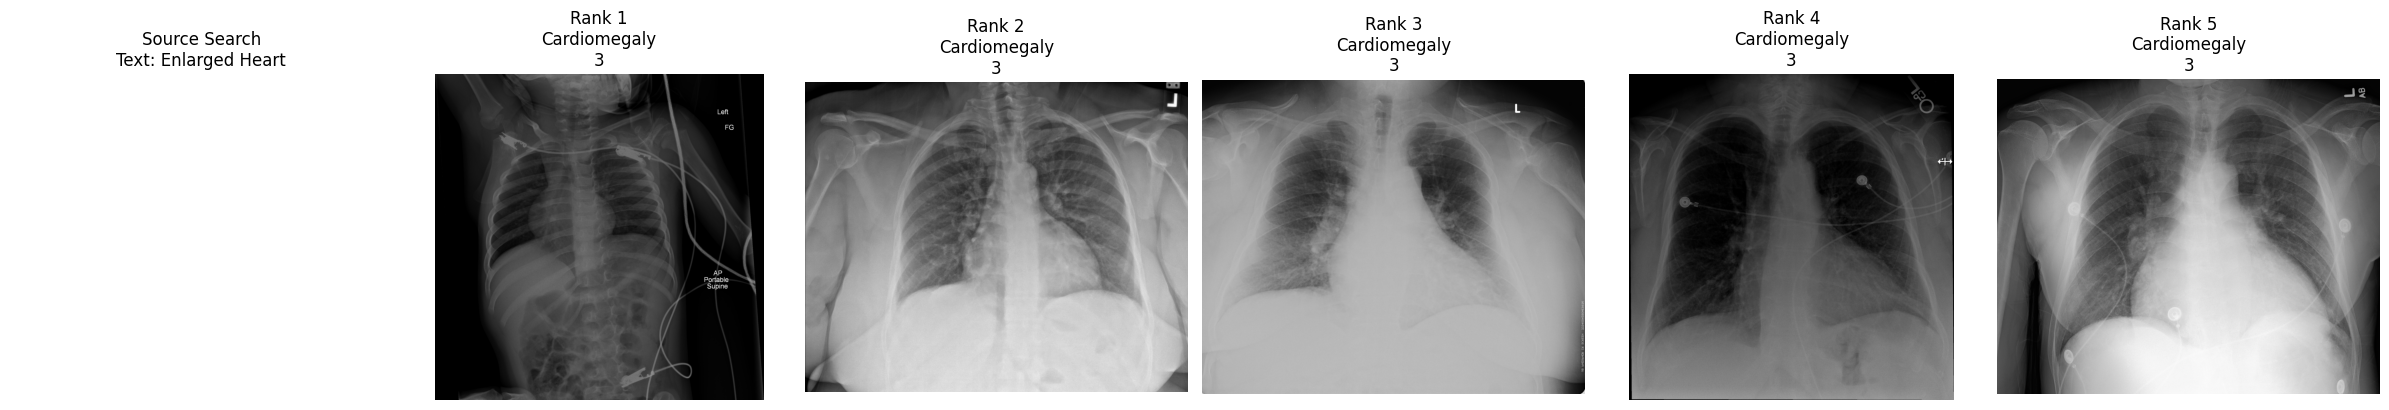

In [9]:
display_source_and_text_search_results("Enlarged Heart", aoai_client=aoai_client, search_client=search_client, k=5)

Now we will do a search using the image vector to find similar images based on the image content.

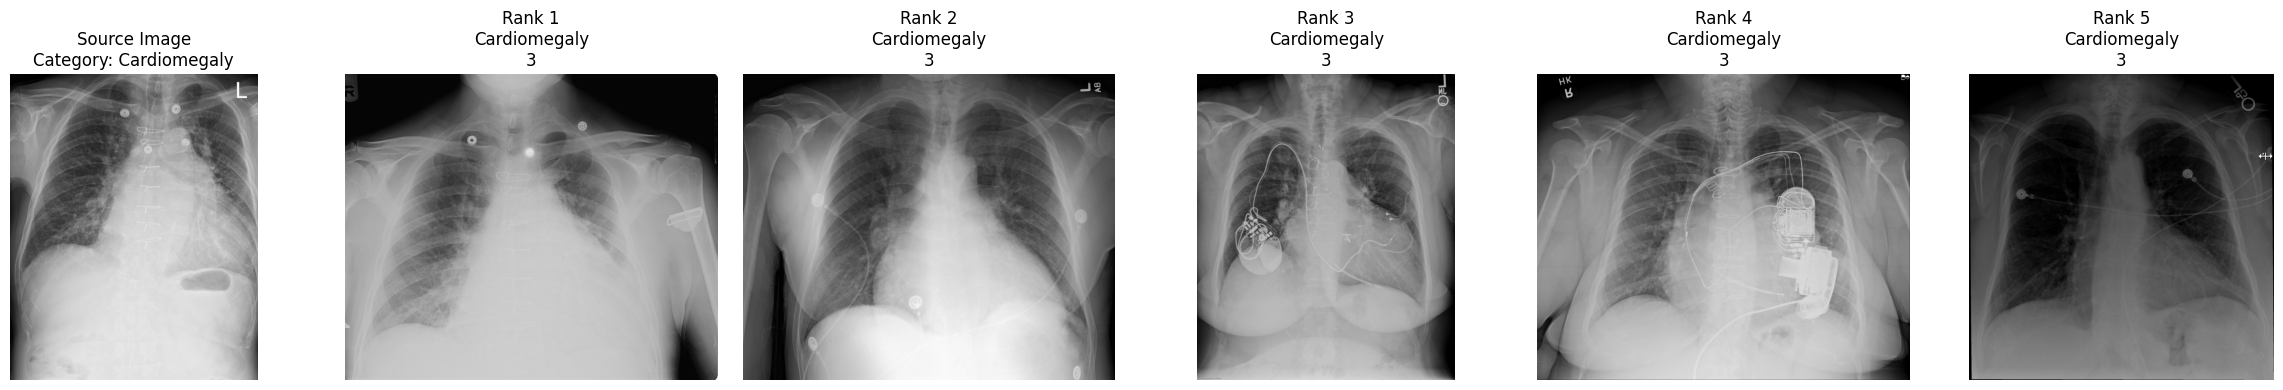

In [16]:
display_source_and_image_search_results(documents=documents, doc_index=18, search_client=search_client, k=5)

With this search, we want to measure the performance of our baseline search to showcase the capability. For this we will be using **precision** at 1, 3, and 5 retrievals.

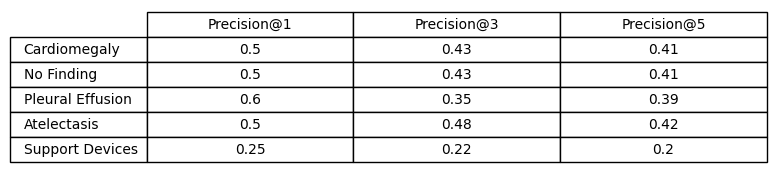

In [17]:
avg_precision = evaluate_precision_at_k(search_client, documents)
display_precision_table(avg_precision)

This is the baseline performance of our search, and we acknowledge we can improve the performance of the system by including some of our improvement techniques.

### 5. Optimizing Performance and Image Search ⚡

This notebook demonstrates a robust baseline for using AI Search with medical images. However, real-world scenarios require continuous improvement and finetuning is required to make the most of the baseline capability. We recognize for this example that the MedImageInsight model is a simple embedding model that can be further optimized for better performance to address the problem of classification. You can also update the model to include more complex architectures like **ResNet, EfficientNet, or Vision Transformers** to improve the quality of the embeddings.

For more information on the details of this work and how to achieve higher accuracy on this same message prompt, please refer to our colleagues work available here:
[Discovering the Power of Finetuning MedImageInsight on Your Data](https://techcommunity.microsoft.com/blog/healthcareandlifesciencesblog/discovering-the-power-of-finetuning-medimageinsight-on-your-data/4395057) 📘

Here is example boiler plate code you can use to begin fine-tuning the model today which sources some of the reference material. This code is retrofitted to using the `MediIndexer` framework. Using this in conjunction with the medical embeddings, these can be used to further refine the embedding space representation and can be used as a replacement of the embeddings inside the of index. The training can be run on CUDA GPU or CPU.

```python
import torch
from src.finetuning.embedding import ClassificationRetrievalModel
from src.finetuning import training

adapter_emb_size = 254

documentsDf = pd.DataFrame(documents)

# Perform a stratified split to keep an even distribution of label_category
train_df, test_df = train_test_split(
    documentsDf,
    test_size=0.2,                    # 20% for testing, 80% for training
    stratify=df['label_category'],    # ensures even distribution in both splits
    random_state=42                   # for reproducibility
)

batch_sz = 32
workers = 4
pin_mem = True

# Create DataLoaders using the build_loader method
train_loader = create_data_loader_from_df(train_df, mode="train")
test_loader  = create_data_loader_from_df(test_df, mode="val")

model = ClassificationRetrievalModel(in_channels=1024, hidden_dim=adapter_emb_size, num_class=5)
loss_function_ts = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=0.0002)

max_epoch = 15
best_accuracy, best_auc = training.train_model(
    train_loader,
    test_loader,
    model,
    loss_function_ts,
    optimizer,
    num_epochs=max_epoch,
)
print(f"Best Accuracy of the Adaptor: {best_accuracy:.4f}")
print(f"Best AUC of the Adaptor: {best_auc:.4f}")
```


---

Embrace the power of AI in healthcare and enjoy the journey of building innovative solutions that can impact patient care! Happy coding and exploring! 😊